In [1]:
import numpy as np
import tensorflow as tf
import utils

import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# pylint: disable=unused-import
import gzip
import os
import tempfile
import pandas as pd
import time

np.random.seed(0)
tf.set_random_seed(0)

/Users/dawnstear/desktop/tensorflow_update/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/dawnstear/desktop/tensorflow_update/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:

#try: data
#except: data  =  pd.read_csv('/Users/dawnstear/desktop/Mid_Atlantic_Poster/sc_data/n_1078/data.csv')  
#data = shuffle(data)
#celltypes = data['TYPE'] # save cell type vector in case we need it later
#y = data['Labels'] # save labels
#X = data.drop(['Labels','TYPE'],axis=1) 
#assert not np.any(np.isnan(X))
#assert not np.any(np.isnan(y))
############################################

try: data13k, labels13k
except: 
    data13k  =  pd.read_csv('/Users/dawnstear/desktop/Mid_Atlantic_Poster/sc_data/n_13313_singlenuc/Mouse_Processed_GTEx_Data.DGE.log-UMI-Counts.txt',sep='\t')  
    data13k = data13k.T
    labels13k  =  pd.read_csv('/Users/dawnstear/desktop/Mid_Atlantic_Poster/sc_data/n_13313_singlenuc/metadata_singleNuc_13k.txt',sep='\t')

data13k_clipped = data13k.iloc[1:] # clip off first row (gene names)   
labels13k_clipped = labels13k.iloc[1:]  # same idea for labels
y = labels13k_clipped # save labels
X = data13k_clipped.values
assert len(labels13k_clipped) == len(data13k_clipped)
y = y['ClusterID']

# sound ding when done

In [4]:
cellcount, genecount = np.shape(X)
n_samples = cellcount
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=144)

# Create Data Object for batch retrieval
batchObj = utils.Data(X,y)


In [5]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)


class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.  """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=1e-7, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon   REPARAMETERIZED________///
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1']),name='rec_lay1') 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2']),name='rec_lay2') 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'],name='z_meannnnn')
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
        
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.   set prior distro lower than -0.5
        # REPARAMETERIZATION is done in this step..
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
#print(tf.trainable_variables())

In [6]:
def train(network_architecture, learning_rate=1e-6,
          batch_size=100, training_epochs=50, display_step=4):
    
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=1e-6, 
                                 batch_size=batch_size)
    TrainLossVec = []
    # Training cycle
    for epoch in range(training_epochs): # implement early stopping
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            
            X_train_batch, y_train_batch = batchObj.train_batch(batch_size=batch_size)
            # Fit training using batch data
            cost = vae.partial_fit(X_train_batch)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            
        TrainLossVec = np.append(TrainLossVec,avg_cost)
        # Display logs per epoch step
        #if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(avg_cost))
        
        if avg_cost<0: 
            current_epoch = epoch
            fig, ax = plt.subplots()
            ax.plot(range(current_epoch+1),TrainLossVec)
            ax.set(xlabel='Epoch', ylabel='Train Loss',title='Loss Over Training Phase') # include time//epoch//batch size in title
            ax.grid()   
            return vae
            
    fig, ax = plt.subplots()
    ax.plot(range(training_epochs),TrainLossVec)
    ax.set(xlabel='Epoch', ylabel='Train Loss',title='Loss Over Training Phase') # include time//epoch//batch size in title
    ax.grid()    
    return vae

Epoch: 0001 cost= 11872.493594724
Epoch: 0002 cost= 11485.466053505
Epoch: 0003 cost= 11073.713575312
Epoch: 0004 cost= 10626.223604278
Epoch: 0005 cost= 10132.128326753
Epoch: 0006 cost= 9569.853663067
Epoch: 0007 cost= 8916.373438732
Epoch: 0008 cost= 8174.093545636
Epoch: 0009 cost= 7386.808685736
Epoch: 0010 cost= 6608.606546614
Epoch: 0011 cost= 5927.900657634
Epoch: 0012 cost= 5380.880996107
Epoch: 0013 cost= 4977.329159879
Epoch: 0014 cost= 4686.795342634
Epoch: 0015 cost= 4461.242645523
Epoch: 0016 cost= 4286.384387558
Training Time: 17.0 minutes and 41.95453405380249 seconds


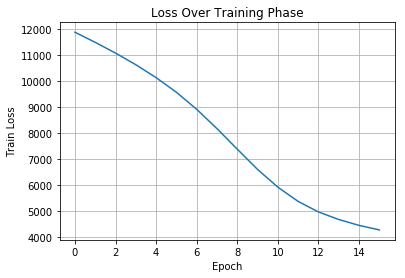

In [7]:
# VAE's dont work well when n << d because the wide variance causes the 
# KL divergence to blow up. For this reason we might want to widen the 
# prior distro?, easiest way to do this is to lower the 0.5 in the KL divergence
# definition.
# Try normalizing the input to zero mean / unit variance
# Lets use some data where n << d

network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=genecount, # total feature space (# of genes)
         n_z=2)  # dimensionality of latent space

t = time.time()

vae = train(network_architecture, training_epochs=16)       

time_elapsed = time.time() - t
print('Training Time: %s minutes and %s seconds' % ((time_elapsed//60),(time_elapsed%60)))

In [8]:
#print(tf.trainable_variables())   what is an acceptable level of error/cost ?  
#~ --see how the latent space clusters

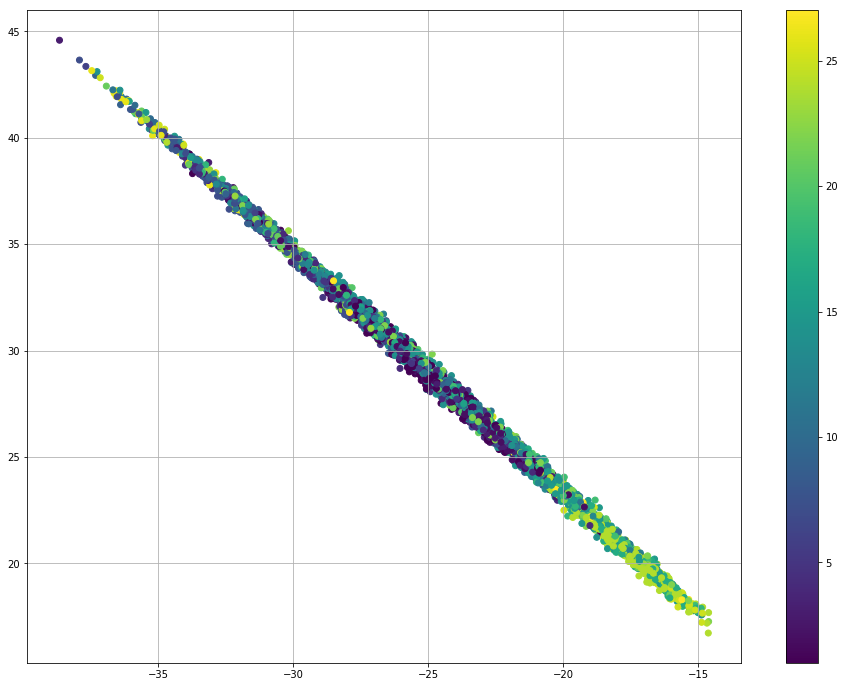

In [8]:
'''
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()
'''

batch_size = 5000
xsample, ysample = batchObj.train_batch(batch_size=batch_size) #next_batch(batch_size,X_train_batch, y_batch)
z_mu = vae.transform(xsample)
plt.figure(figsize=(16,12))
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=ysample)#c=np.argmax(ysample, 1))
plt.colorbar()
plt.grid()

